# Recipe: Cognitive Services - Multivariate Anomaly Detection 
This recipe shows how you can use SynapseML and Azure Cognitive Services on Apache Spark for multivariate anomaly detection. Multivariate anomaly detection allows for the detection of anomalies among many variables or timeseries, taking into account all the inter-correlations and dependencies between the different variables. In this scenario, we use SynapseML to train a model for multivariate anomaly detection using the Azure Cognitive Services, and we then use to the model to infer multivariate anomalies within a dataset containing synthetic measurements from three IoT sensors. 

To learn more about the Anomaly Detector Cognitive Service please refer to [ this documentation page](https://docs.microsoft.com/en-us/azure/cognitive-services/anomaly-detector/). 

### Prerequisites
- An Azure subscription - [Create one for free](https://azure.microsoft.com/en-us/free/)

### Setup
#### Create an Anomaly Detector resource
Follow the instructions below to create an `Anomaly Detector` resource using the Azure portal or alternatively, you can also use the Azure CLI to create this resource.

- In the Azure Portal, click `Create` in your resource group, and then type `Anomaly Detector`. Click on the Anomaly Detector resource.
- Give the resource a name, and ideally use the same region as the rest of your resource group. Use the default options for the rest, and then click `Review + Create` and then `Create`.
- Once the Anomaly Detector resource is created, open it and click on the `Keys and Endpoints` panel on the left. Copy the key for the Anomaly Detector resource into the `ANOMALY_API_KEY` environment variable, or store it in the `anomalyKey` variable in the cell below.

#### Create a Storage Account resource
In order to save intermediate data, you will need to create an Azure Blob Storage Account. Within that storage account, create a container for storing the intermediate data. Make note of the container name, and copy the connection string to that container. You will need this later to populate the `containerName` variable and the `BLOB_CONNECTION_STRING` environment variable.

#### Enter your service keys
Let's start by setting up the environment variables for our service keys. The next cell sets the `ANOMALY_API_KEY` and the `BLOB_CONNECTION_STRING` environment variables based on the values stored in our Azure Key Vault. If you are running this in your own environment, make sure you set these environment variables before you proceed.

In [ ]:
import os

if os.environ.get("AZURE_SERVICE", None) == "Microsoft.ProjectArcadia":
    from pyspark.sql import SparkSession
    spark = SparkSession.builder.getOrCreate()
    from notebookutils.mssparkutils.credentials import getSecret
    os.environ['ANOMALY_API_KEY'] = getSecret(
        "mmlspark-keys", "anomaly-api-key")
    os.environ['BLOB_CONNECTION_STRING'] = getSecret(
        "mmlspark-keys", "madtest-connection-string")

Now, lets read the `ANOMALY_API_KEY` and `BLOB_CONNECTION_STRING` environment variables and set the `containerName` and `location` variables.

In [ ]:
# An Anomaly Dectector subscription key
anomalyKey = os.environ["ANOMALY_API_KEY"]
# A connection string to your blob storage account
connectionString = os.environ["BLOB_CONNECTION_STRING"]
# The name of the container where you will store intermediate data
containerName = "intermediate-data-container-name"
# The location of the anomaly detector resource that you created
location = "eastus"

Let's import all the necessary modules.

In [ ]:
import numpy as np
import pandas as pd

import pyspark
from pyspark.sql.functions import col
from pyspark.sql.functions import lit
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt

import synapse.ml
from synapse.ml.cognitive import *

Now, let's read our sample data into a Spark DataFrame.

In [ ]:
df = spark.read.format("csv").option("header", "true").load("wasbs://publicwasb@mmlspark.blob.core.windows.net/MVAD/sample.csv")

df = df.withColumn("sensor_1", col("sensor_1").cast(DoubleType())) \
    .withColumn("sensor_2", col("sensor_2").cast(DoubleType())) \
    .withColumn("sensor_3", col("sensor_3").cast(DoubleType()))

# Let's inspect the dataframe:
df.show(5)

+---+--------------------+-------------------+------------------+-------------------+
_c0| timestamp| sensor_1| sensor_2| sensor_3|
+---+--------------------+-------------------+------------------+-------------------+
 0|2020-06-01T12:00:00Z|0.14166661772351746| 1.64694911007051|-1.3881337018488558|
 1|2020-06-01T12:05:00Z| 0.1305933229498391|1.6922392241428175|-1.2806036390212636|
 2|2020-06-01T12:10:00Z|0.18845845390026034|1.6622384680787263| -1.339436407853147|
 3|2020-06-01T12:15:00Z|0.25971913318984785|1.7223061325727624|-1.4333591951793734|
 4|2020-06-01T12:20:00Z|0.20488469276562699|1.6253502821289068|-1.4857026449152702|
+---+--------------------+-------------------+------------------+-------------------+
only showing top 5 rows

We can now create an `estimator` object, which will be used to train our model. In the cell below, we specify the start and end times for the training data. We also specify the input columns to use, and the name of the column that contains the timestamps.

In [ ]:
trainingStartTime = "2020-06-01T12:00:00Z"
trainingEndTime = "2020-07-02T17:55:00Z"
intermediateSaveDir = "intermediateData" 
timestampColumn = "timestamp"
inputColumns = ["sensor_1", "sensor_2", "sensor_3"]


estimator = (FitMultivariateAnomaly()
    .setSubscriptionKey(anomalyKey)
    .setLocation("eastus")
    .setStartTime(trainingStartTime)
    .setEndTime(trainingEndTime)
    .setContainerName(containerName)
    .setIntermediateSaveDir(intermediateSaveDir)
    .setTimestampCol(timestampColumn)
    .setInputCols(inputColumns)
    .setConcurrency(5)
    .setSlidingWindow(200)
    .setConnectionString(connectionString)
     )

Now that we have created the `estimator`, let's fit it to the data:

In [ ]:
model = estimator.fit(df)

Once the training is done, we can now use the model for inference. The code in the next cell specifies the start and end times for the data we would like to detect the anomlies in. It will then show the results.

In [ ]:
inferenceStartTime = "2020-07-02T18:00:00Z"
inferenceEndTime = "2020-07-06T05:15:00Z"

result = (model
    .setStartTime(inferenceStartTime)
    .setEndTime(inferenceEndTime)
    .setOutputCol("results")
    .setErrorCol("errors")
    .setInputCols(inputColumns)
    .setTimestampCol(timestampColumn)
    .transform(df)
     )

result.show(5)

+--------------------+-------------------+------------------+-------------------+------+-------+---------+
 timestamp| sensor_1| sensor_2| sensor_3|errors|results|isAnomaly|
+--------------------+-------------------+------------------+-------------------+------+-------+---------+
2020-06-01T12:00:00Z|0.14166661772351746| 1.64694911007051|-1.3881337018488558| null| null| null|
2020-06-01T12:05:00Z| 0.1305933229498391|1.6922392241428175|-1.2806036390212636| null| null| null|
2020-06-01T12:10:00Z|0.18845845390026034|1.6622384680787263| -1.339436407853147| null| null| null|
2020-06-01T12:15:00Z|0.25971913318984785|1.7223061325727624|-1.4333591951793734| null| null| null|
2020-06-01T12:20:00Z|0.20488469276562699|1.6253502821289068|-1.4857026449152702| null| null| null|
+--------------------+-------------------+------------------+-------------------+------+-------+---------+
only showing top 5 rows

When we called `.show(5)` in the previous cell, it showed us the first five rows in the dataframe. The results were all `null` because they were not inside the inferrence window.

To show the results only for the infferred data, lets select the columns we need. We can then order the rows in the dataframe by ascending order, and filter the result to only show the rows that are in the range of the inference window. In our case `inferenceEndTime` is the same as the last row in the dataframe, so can ignore that. 

Finally, to be able to better plot the results, lets convert the Spark dataframe to a Pandas dataframe.

This is what the next cell does:

In [ ]:
rdf = result.select("timestamp",*inputColumns, "results.contributors", "results.isAnomaly", "results.severity").orderBy('timestamp', ascending=True).filter(col('timestamp') >= lit(inferenceStartTime)).toPandas()
rdf

/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field contributors. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: ArrayType(StructType(List(StructField(contributionScore,DoubleType,true),StructField(variable,StringType,true))),true)
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)
Out[8]:

,timestamp,sensor_1,sensor_2,sensor_3,contributors,isAnomaly,severity
0,2020-07-02T18:00:00Z,1.069680,0.393173,3.129125,None,False,0.00000
1,2020-07-02T18:05:00Z,0.932784,0.214959,3.077339,"[(0.5516611337661743, series_1), (0.3133429884...",True,0.06478
2,2020-07-02T18:10:00Z,1.012214,0.466037,2.909561,None,False,0.00000
3,2020-07-02T18:15:00Z,1.122182,0.398438,3.029489,None,False,0.00000
4,2020-07-02T18:20:00Z,1.091310,0.282137,2.948016,None,False,0.00000
...,...,...,...,...,...,...,...
995,2020-07-06T04:55:00Z,-0.443438,0.768980,-0.710800,None,False,0.00000
996,2020-07-06T05:00:00Z,-0.529400,0.822140,-0.944681,None,False,0.00000
997,2020-07-06T05:05:00Z,-0.377911,0.738591,-0.871468,None,False,0.00000
998,2020-07-06T05:10:00Z,-0.501993,0.727775,-0.786263,None,False,0.00000


Let's now format the `contributors` column that stores the contribution score from each sensor to the detected anomalies. The next cell formats this data, and splits the contribution score of each sensor into its own column.

In [ ]:
def parse(x):
    if type(x) is list:
        return dict([item[::-1] for item in x])
    else:
        return {'series_0': 0, 'series_1': 0, 'series_2': 0}

rdf['contributors'] = rdf['contributors'].apply(parse)
rdf = pd.concat([rdf.drop(['contributors'], axis=1), pd.json_normalize(rdf['contributors'])], axis=1)
rdf

Out[9]:

,timestamp,sensor_1,sensor_2,sensor_3,isAnomaly,severity,series_0,series_1,series_2
0,2020-07-02T18:00:00Z,1.069680,0.393173,3.129125,False,0.00000,0.000000,0.000000,0.000000
1,2020-07-02T18:05:00Z,0.932784,0.214959,3.077339,True,0.06478,0.313343,0.551661,0.134996
2,2020-07-02T18:10:00Z,1.012214,0.466037,2.909561,False,0.00000,0.000000,0.000000,0.000000
3,2020-07-02T18:15:00Z,1.122182,0.398438,3.029489,False,0.00000,0.000000,0.000000,0.000000
4,2020-07-02T18:20:00Z,1.091310,0.282137,2.948016,False,0.00000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
995,2020-07-06T04:55:00Z,-0.443438,0.768980,-0.710800,False,0.00000,0.000000,0.000000,0.000000
996,2020-07-06T05:00:00Z,-0.529400,0.822140,-0.944681,False,0.00000,0.000000,0.000000,0.000000
997,2020-07-06T05:05:00Z,-0.377911,0.738591,-0.871468,False,0.00000,0.000000,0.000000,0.000000
998,2020-07-06T05:10:00Z,-0.501993,0.727775,-0.786263,False,0.00000,0.000000,0.000000,0.000000


Great! We now have the contribution scores of sensors 1, 2, and 3 in the `series_0`, `series_1`, and `series_2` columns respectively. 

Let's run the next cell to plot the results.

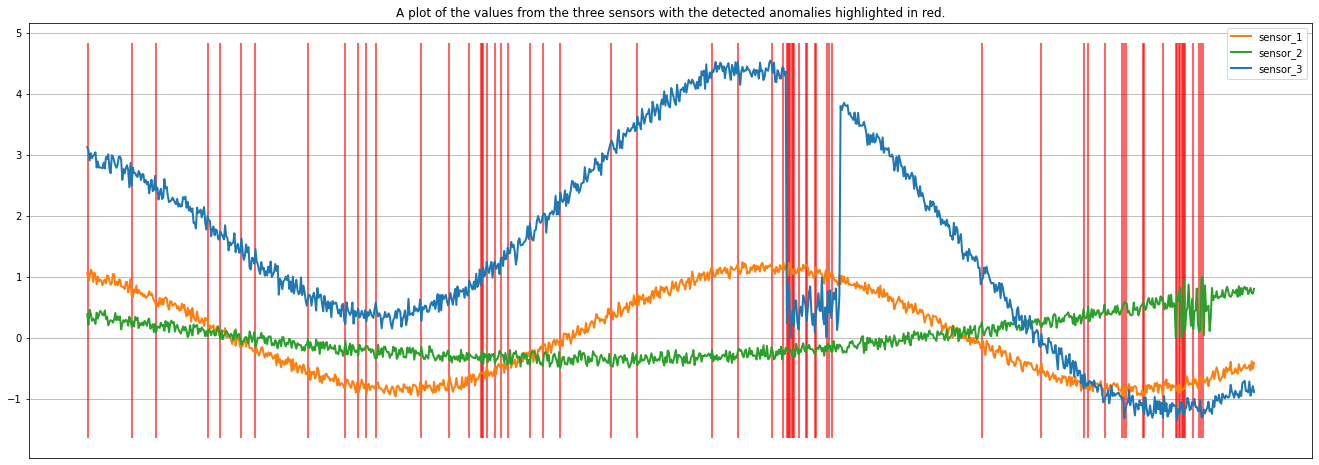

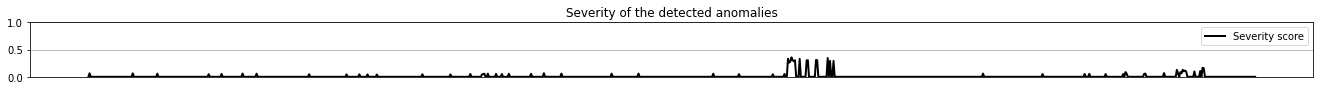

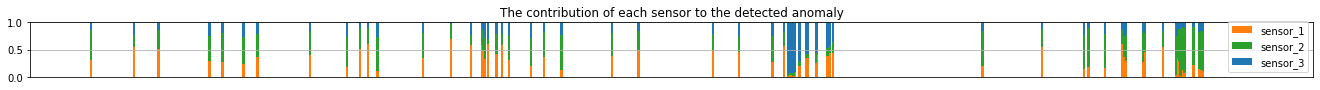

In [ ]:
### Main Figure ###
plt.figure(figsize=(23,8))
plt.plot(rdf['timestamp'],rdf['sensor_1'], color='tab:orange', linestyle='solid', linewidth=2, label='sensor_1')
plt.plot(rdf['timestamp'],rdf['sensor_2'], color='tab:green', linestyle='solid', linewidth=2, label='sensor_2')
plt.plot(rdf['timestamp'],rdf['sensor_3'], color='tab:blue', linestyle='solid', linewidth=2, label='sensor_3')
plt.grid(axis='y')
plt.tick_params(axis='x',which='both',bottom=False,labelbottom=False)
plt.legend()

anoms = list(rdf["isAnomaly"] == True)
_, _, ymin, ymax = plt.axis()
plt.vlines(np.where(anoms), ymin=ymin , ymax=ymax , color='r', alpha=0.8)

plt.legend()
plt.title('A plot of the values from the three sensors with the detected anomalies highlighted in red.')
plt.show()

### Severity Figure ###
plt.figure(figsize=(23,1))
plt.tick_params(axis='x',which='both',bottom=False,labelbottom=False)
plt.plot(rdf['timestamp'],rdf['severity'], color='black', linestyle='solid', linewidth=2, label='Severity score')
plt.grid(axis='y')
plt.legend()
plt.ylim([0,1])
plt.title("Severity of the detected anomalies")
plt.show()

### Contributors Figure ###
plt.figure(figsize=(23,1))
plt.tick_params(axis='x',which='both',bottom=False,labelbottom=False)
plt.bar(rdf['timestamp'],rdf['series_0'], width=2, color='tab:orange', label='sensor_1')
plt.bar(rdf['timestamp'],rdf['series_1'], width=2, color='tab:green', label='sensor_2', bottom=rdf['series_0'])
plt.bar(rdf['timestamp'],rdf['series_2'], width=2, color='tab:blue', label='sensor_3', bottom=rdf['series_0']+rdf['series_1'])
plt.grid(axis='y')
plt.legend()
plt.ylim([0,1])
plt.title("The contribution of each sensor to the detected anomaly")
plt.show()


The plots above show the raw data from the sensors (in the inference window) in orange, green, and blue. The red vertical lines in the first figure show the detected anomalies in this window. 

The second plot shows the severity score of each deteced anomaly.

Finally, the last plot shows the contribution of the data from each sensor to the detected anomalies. This helps us diagnose and understand the most likely cause of each anomaly.